In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import matplotlib.ticker as ticker
from matplotlib import rcParams, cm, patches
from mpl_toolkits.mplot3d import Axes3D
from scipy import io, integrate
from sklearn import linear_model
import os
from utilities import DMD, forecastDMD, matrixDelay, centralSchemeDerivative, LSLF, lotka_rhs, regression, buildLibrary, sparsifyDynamics, optDE1220


In [3]:
## GET POPULATION

path = '.' #os.path.dirname(os.path.realpath(__file__))
path = os.path.join(path, 'data')
name = os.path.join(path, 'animals_population.mat')

population_mat = io.loadmat(name)
population_full = population_mat['pop']
years = population_mat['years'][0]
years_r = years[:-2]
time_full = (years-years[0])*(365*24*60*60)
population = population_full[:,:-2]
time = time_full[:-2]
deltaT = time[1]-time[0]


In [4]:
## BASIC DMD
n = len(population[1,:])
r = 2
U, S, Vt = np.linalg.svd(population, full_matrices=False)

X = population[:,:n-1]
X1 = population[:,1:]

Phi, Lambda, b = DMD(X,X1,r)
u_dmd, Omega = forecastDMD(Phi, Lambda, b, time_full)

omega = np.diag(Omega)
omega_a = omega*deltaT


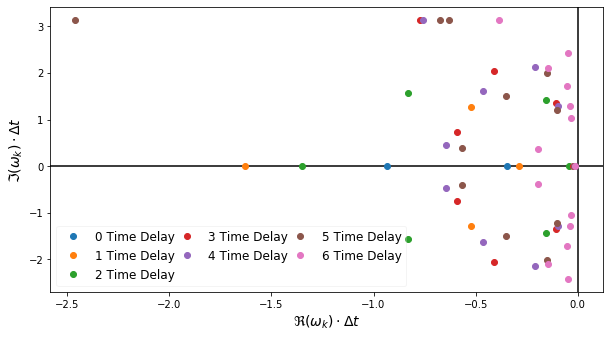

In [5]:
## TIME-DELAYED DMD
n_delay = 3
n_delay_vec = np.arange(7)

fig_2, ax_2 = plt.subplots(figsize=1.2*plt.figaspect(0.56), tight_layout=True)
ax_2.axhline(y=0, color="black", linestyle="-")
ax_2.axvline(x=0, color="black", linestyle="-")
ax_2.set_xlabel(xlabel= r'$\Re{({\omega}_k)} \cdot \Delta t$', fontsize=14)
ax_2.set_ylabel(ylabel= r'$\Im{({\omega}_k)} \cdot \Delta t$', fontsize=14)

for n_delay in n_delay_vec:

    r_td = 22
    H = matrixDelay(population, n_delay)
    U_td, S_td, Vt_td = np.linalg.svd(H, full_matrices=False)

    n_td = H.shape[1]
    X_td = H[:,:n_td-1]
    X1_td = H[:,1:]

    if r_td>int(np.amin(X_td.shape)):
        r_td = int(np.amin(X_td.shape))

    Phi_td, Lambda_td, b_td = DMD(X_td,X1_td,r_td)
    u_td_dmd, Omega_td = forecastDMD(Phi_td, Lambda_td, b_td, time_full)

    omega_td = np.diag(Omega_td)
    omega_td_a = omega_td*deltaT

    ax_2.plot(np.real(omega_td_a), np.imag(omega_td_a), 'o', markersize=6, label=r'{} Time Delay'.format(n_delay))

legend = ax_2.legend(fontsize=12, loc=3, ncol=3, columnspacing=0, framealpha=0.2)
#fig_2.savefig('..\\report_latex\\es1_omega_comparison.eps', transaprent=True)
plt.show()


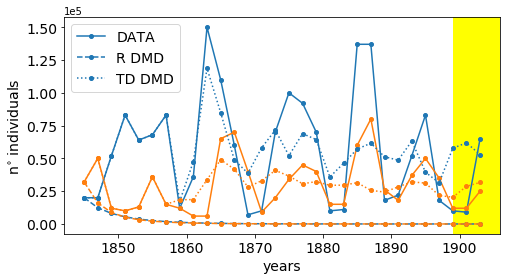

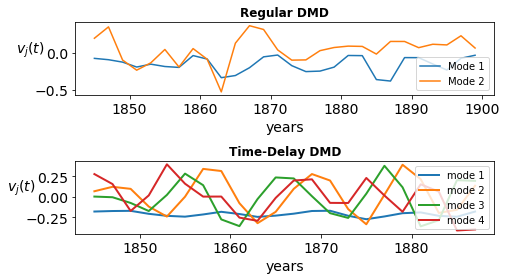

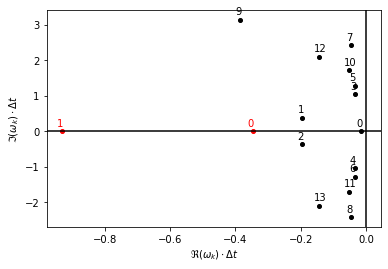

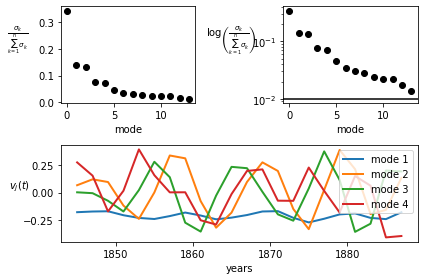

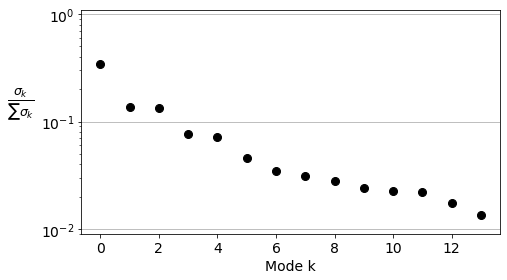

In [6]:
##  DMD PLOTS

fig_0, ax_0 = plt.subplots(figsize=plt.figaspect(0.56), tight_layout=True)
bl1 = ax_0.plot(years, population_full[0], 'o-', linewidth = 1.5,  markersize=4, label='DATA')
bl2 = ax_0.plot(years, population_full[1], 'o-', linewidth = 1.5, markersize=4)
color1 = bl1[0].get_color()
color2 = bl2[0].get_color()
ax_0.plot(years, u_dmd[0,:], 'o--', color= color1, linewidth = 1.5, markersize=4, label = 'R DMD')
ax_0.plot(years, u_dmd[1,:], 'o--', color= color2, linewidth = 1.5, markersize=4)
ax_0.plot(years, u_td_dmd[0,:], 'o:', color= color1, linewidth = 1.5, markersize=4, label = 'TD DMD')
ax_0.plot(years, u_td_dmd[1], 'o:', color= color2, linewidth = 1.5, markersize=4)
ax_0.get_xlim()
rect1 = patches.Rectangle((years_r[-1],-1e5), 2*1e7, 1e7, color='yellow')
ax_0.add_patch(rect1)
ax_0.set_xlabel(xlabel='years', fontsize=14)
ax_0.set_ylabel(ylabel= r'n$^{\circ}$ individuals', fontsize=14)
legend = ax_0.legend(fontsize=14)
ax_0.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax_0.tick_params(axis='x', labelsize=14)
ax_0.tick_params(axis='y', labelsize=14)
#fig_0.savefig('..\\report_latex\\es1_DMD_comparison.eps', transaprent=True)


fig_1, ax_1 = plt.subplots(2,1,figsize=plt.figaspect(0.56), tight_layout=True)
[ax_1[0].plot(years_r, Vt[k,:],linewidth=1.5,label='Mode {}'.format(k+1)) for k in range(len(Vt[:,0]))]
ax_1[0].set_xlabel(xlabel='years', fontsize=14)
ax_1[0].set_ylabel(ylabel= r'$v_j (t)$', fontsize=14, rotation=0)
ax_1[0].legend()
#ax_1.grid()
ax_1[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax_1[0].tick_params(axis='x', labelsize=14)
ax_1[0].tick_params(axis='y', labelsize=14)
ax_1[0].set_title('Regular DMD', fontweight='bold')
[ax_1[1].plot(years[:len(years_r)-n_delay], Vt_td[k,:],linewidth=2,label='mode {}'.format(k+1)) for k in range(4)]
ax_1[1].set_xlabel(xlabel='years', fontsize=14)
ax_1[1].set_ylabel(ylabel= r'$v_j (t)$', fontsize=14, rotation=0)
ax_1[1].legend()
#ax_1.grid()
ax_1[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax_1[1].tick_params(axis='x', labelsize=14)
ax_1[1].tick_params(axis='y', labelsize=14)
ax_1[1].set_title('Time-Delay DMD', fontweight='bold')
#fig_1.savefig('..\\report_latex\\es1_mode_comparison.eps', transaprent=True)


fig_2, ax_2 = plt.subplots()
ax_2.plot(np.real(omega_a), np.imag(omega_a), 'ro', markersize=4)
ax_2.axhline(y=0, color="black", linestyle="-")
ax_2.axvline(x=0, color="black", linestyle="-")
for i in range(len(omega_a)):
    plt.annotate(r'{}'.format(i), xy=(np.real(omega_a[i]), np.imag(omega_a[i])), \
        xytext=(-5,5), textcoords='offset points', color='r')
ax_2.set(xlabel= r'$\Re{({\omega}_k)} \cdot \Delta t$', ylabel= r'$\Im{({\omega}_k)} \cdot \Delta t$')


ax_2.plot(np.real(omega_td_a), np.imag(omega_td_a), 'ko', markersize=4)
for i in range(len(omega_td_a)):
    ax_2.annotate(r'{}'.format(i), xy=(np.real(omega_td_a[i]), np.imag(omega_td_a[i])), \
        xytext=(-5,5), textcoords='offset points', color='k')

fig_3 = plt.figure()
ax_upl = plt.subplot(2,2,1)
ax_upl.plot(S_td/np.sum(S_td), 'ko')
ax_upl.set(xlabel='mode')
ax_upl.set_ylabel(ylabel= r'$\frac{{\sigma}_k}{\sum_{k=1}^n {\sigma}_k}$', rotation=0, labelpad=20)
ax_upr = plt.subplot(2,2,2)
ax_upr.semilogy(S_td/np.sum(S_td), 'ko')
ax_upr.axhline(y=1e-2, color="black", linestyle="-")
ax_upr.set(xlabel='mode')
ax_upr.set_ylabel(ylabel= r'$\log \left( \frac{{\sigma}_k}{\sum_{k=1}^n {\sigma}_k} \right)$', rotation=0, labelpad=20)

ax_dn = plt.subplot(2,1,2)
[ax_dn.plot(years[:len(years_r)-n_delay], Vt_td[k,:],linewidth=2,label='mode {}'.format(k+1)) for k in range(4)]
legend = ax_dn.legend()
ax_dn.set(xlabel='years')
ax_dn.set_ylabel(ylabel= r'$v_j (t)$', rotation=0)
fig_3.tight_layout()

fig_3, ax_3 = plt.subplots(figsize=plt.figaspect(0.56), tight_layout=True)
ax_3.semilogy(S_td/np.sum(S_td), 'ko', markersize=8)
#ax_3.axhline(y=1e-2, color="black", linestyle="-")
ax_3.set_xlabel(xlabel='Mode k', fontsize=14)
ax_3.set_ylabel(ylabel= r'$ \frac{{\sigma}_k}{\sum {\sigma}_k} $', fontsize=18, rotation=0, labelpad=20)
ax_3.tick_params(axis='x', labelsize=14)
ax_3.tick_params(axis='y', labelsize=14)
ax_3.grid(axis='y')
ax_3.set_ylim([0.009, 1.1])
#fig_3.savefig('..\\report_latex\\es1_singular_values.eps', transaprent=True)




plt.show()

In [7]:
## FIT TO PRE-DEFINED MODELS
# Lotka-Volterra Predator-Prey models
# x_dot = (b-py)x
# y_dot = (rx-d)y

X = population_full
X0 = X[:,0]

t = years-years[0]
Dt = [t[0], t[-1]]

b = 0.58
p = 1.3*1e-5
d = 0.45
r = 1.1*1e-5

sol = integrate.solve_ivp(lotka_rhs, Dt , X0, t_eval =t,\
        args = (b,p,d,r), method='Radau')
X_p = sol.y

Err = np.linalg.norm(X-X_p,ord=2)/np.linalg.norm(X,ord=2)

print('The mean square error is: {:5.5f}'.format(Err))




The mean square error is: 0.56015


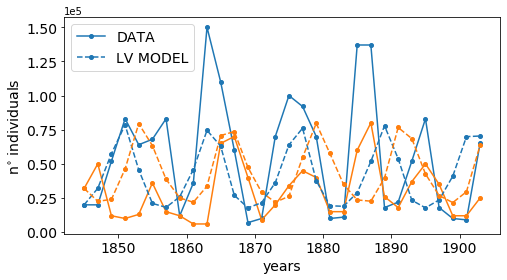

In [8]:
##  PLOTS

fig_0, ax_0 = plt.subplots(figsize=plt.figaspect(0.56), tight_layout=True)
bl1 = ax_0.plot(years, X[0,:], 'o-', linewidth = 1.5,  markersize=4, label='DATA')
bl2 = ax_0.plot(years, X[1,:], 'o-', linewidth = 1.5, markersize=4)
color1 = bl1[0].get_color()
color2 = bl2[0].get_color()
ax_0.plot(years, X_p[0,:], 'o--', color= color1, linewidth = 1.5, markersize=4, label = 'LV MODEL')
ax_0.plot(years, X_p[1,:], 'o--', color= color2, linewidth = 1.5, markersize=4)
ax_0.get_xlim()
ax_0.set_xlabel(xlabel='years', fontsize=14)
ax_0.set_ylabel(ylabel= r'n$^{\circ}$ individuals', fontsize=14)
legend = ax_0.legend(fontsize=14)
ax_0.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax_0.tick_params(axis='x', labelsize=14)
ax_0.tick_params(axis='y', labelsize=14)
#fig_0.savefig('..\\report_latex\\es1_LV_comparison.eps', transaprent=True)

Xi_x       Xi_y
1            26.210870   9.763646
x0            5.312784   6.496754
x1           -5.073913  11.060665
x0*x0         0.000000   0.000000
x0*x1         0.000000   0.000000
x1*x1        -3.475666  -3.976708
x0*x0*x0     -1.100657  -0.000000
x0*x0*x1     -0.823490   0.000000
x0*x1*x1      0.000000   0.000000
x1*x1*x1      0.000000   0.000000
x0*x0*x0*x0   2.284822   0.000000
x0*x0*x0*x1   0.792746   0.421825
x0*x0*x1*x1  -0.836249   0.000000
x0*x1*x1*x1   0.000000  -1.345586
x1*x1*x1*x1  -0.339302   0.000000
sin(x0)      -0.000000  -0.000000
cos(x0)       0.000000   0.000000
tan(x0)      -0.000000  -0.000000
sin(x1)      -0.000000  -0.000000
cos(x1)       0.000000   0.609894
tan(x1)      -1.951945  -2.030489
0.3146270717708206


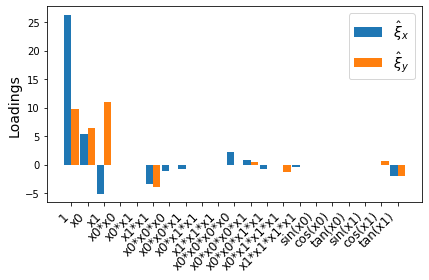

In [9]:
## SEARCHING THE BEST FIT NON-LINEAR, DYNAMICAL SYSTEM MODEL

X = population_full
Xk1 = X[:,1:]
X = X[:,:-1]
X_s = X.T
Xk1_s = Xk1.T
order = 4
    
L, fun_list = buildLibrary(X_s, order, 1, 0, 0, 0)
Xi = sparsifyDynamics(L, Xk1_s, 0.3)

L_ave = np.repeat((np.average(L,axis =0)).reshape((-1,1)), Xk1_s.shape[1], axis=1)
Xi_adim = Xi*L_ave
Xi_adim_rel = Xi_adim/np.average(Xi_adim, axis=0)

Xk1_s_fit = L @ Xi
cols = ['Xi_x', 'Xi_y']
coeff_list = pd.DataFrame(Xi_adim_rel, index=fun_list, columns=cols)
Err_s = np.linalg.norm(Xk1_s-Xk1_s_fit,ord=2)/np.linalg.norm(Xk1_s,ord=2)

print(coeff_list)
print(Err_s)


x = np.arange(len(fun_list))
width = 0.45
fig, ax = plt.subplots(figsize=plt.figaspect(0.66), tight_layout=True)
rects1 = ax.bar(x - width/2, Xi_adim_rel[:,0], width, label=r'$\hat{\xi}_x$')
rects2 = ax.bar(x + width/2, Xi_adim_rel[:,1], width, label=r'$\hat{\xi}_y$')
ax.set_xticks(x)
ax.set_xticklabels(fun_list, fontsize=12)
ax.set_ylabel('Loadings',fontsize=14)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.legend(fontsize=14)
#fig.savefig('..\\report_latex\\es1_loadings.eps', transaprent=True)
plt.show()
